In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV



In [2]:
# Separando as features e a label
X = pd.read_csv("train_w_metricas.csv",index_col=0)
y = X['label']
columns_to_remove = [
    'label', 'code', 'cbo', 'cboModified', 'fanin', 'fanout', 'wmc', 
    'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'lcc'
]
X = X.drop(columns=columns_to_remove, axis=1)

In [3]:
# Aplicando SMOTE para balancear o dataset
smote = SMOTE(random_state=None)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [4]:
# Dividindo os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=None)

In [ ]:
# Criando o modelo GBM com o encontrado pelo H2O
##gbm = GradientBoostingClassifier(random_state=None)
gbm_h2o = GradientBoostingClassifier(
    n_estimators=32,            # Número de árvores
    max_depth=6,                # Profundidade máxima das árvores
    min_samples_leaf=27,        # Número mínimo de amostras por folha
    learning_rate=0.1,         # Taxa de aprendizado
    subsample=1.0,             # Taxa de amostragem de instâncias
)
# Treinando o modelo
gbm_h2o.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, min_samples_leaf=27, n_estimators=32)

In [ ]:
# modelo para usar o gridsearch
gbm = GradientBoostingClassifier(random_state=None)


In [7]:
param_grid = {
    'n_estimators': [50, 100, 150],  # número de árvores
    'max_depth': [3, 5, 7],          # profundidade das árvores
    'learning_rate': [0.01, 0.05, 0.1],  # taxa de aprendizado
    'min_samples_leaf': [10, 20, 30],  # amostras mínimas por folha
    'subsample': [0.8, 1.0]  # taxa de amostragem
}

# Instanciar o GridSearchCV com a métrica de acurácia
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Ajustar o modelo ao conjunto de dados de treino
grid_search.fit(X_train, y_train)

# Ver o melhor conjunto de parâmetros
print("Melhores parâmetros encontrados:", grid_search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores parâmetros encontrados: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_leaf': 30, 'n_estimators': 150, 'subsample': 1.0}


In [11]:
try:
    grid_search.fit(X_train, y_train)
except Exception as e:
    print(f"Ocorreu um erro ao ajustar o modelo: {e}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [12]:
if grid_search.best_estimator_ is None:
    print("Nenhum modelo otimizado encontrado.")
else:
    print("Modelo otimizado:", grid_search.best_estimator_)


Modelo otimizado: GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=10,
                           n_estimators=150, subsample=0.8)


In [13]:
best_model = grid_search.best_estimator_

In [14]:

# Fazer previsões
y_pred = best_model.predict(X_test)

# Avaliar a precisão
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo otimizado: {accuracy:.4f}")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibindo as métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Acurácia do modelo otimizado: 0.7326
Accuracy: 0.7326
Precision: 0.7612
Recall: 0.6296
F1 Score: 0.6892


In [15]:
# Definindo os nomes das variáveis
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Função para plotar a importância das variáveis
def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[-5:]  # Seleciona as 5 variáveis mais importantes

    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.xlabel("Importância")
    plt.title("Variáveis")
    plt.show()

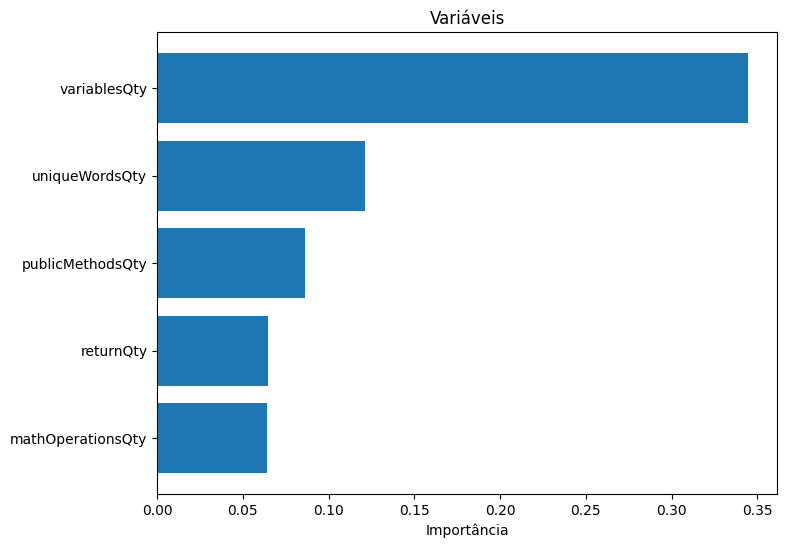

In [18]:
plot_feature_importance(gbm, "Gradient Boosting (GBM)")
